## PROTO V1.0
<div class='alert alert-success'>
Ce petit notebook permet d'évaluer Abstract Torch sur un petit réseau. 
Pour cela, on créé AbstractNN, un petit réseau composé de 3 couches de convolution suivies de ReLU, puis de deux couches FC suivies également de ReLU. 
Pour l'entrainement uniquement, un softmax est appliqué en sortie de réseau
</div>

Dans la classe AbstractNN, la méthode forward de nn.Linear est surchargée de façon standard.
C'est à dire que si l'on instancie model=AbstractNN(), model(x) applique forward à x comme dans n'importe quel réseau. 

AbstractNN possède une méthode abstract_forward() qui fait appelle à AbstractLinear et AbstractReLU. 
<div class='alert alert-info'>
Le lecteur avisé notera que 
    model(x)=nn.softmax(model.abstract_forward(x_abstract)[0])
</div>



In [32]:


%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn

from abstractModule import AbstractLinear as AL
from abstractModule import AbstractReLU as AR
from abstractModule import AbstractMaxpool2D as AM

from util.custom_train import CustomTrainer as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os


device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Ici on importe le dataset FashionMNIST normalisation et random split pour l'entrainement

In [34]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


Ici on génère notre classe AbstractNN et sa fameuse méthode abstrac_forward


In [42]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
        self.maxpool = nn.MaxPool2d(2,2)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(4608,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
        x=self.maxpool(x)
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,add_symbol=False,device=torch.device("cpu")):
        self.device=device
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)

        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
     
       
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        x,x_min,x_max ,x_true = AM.abstract_maxpool2D(self.maxpool,x,x_true)
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
      
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
        
        return x,x_min,x_max,x_true
        

Un petit script pour l'entrainement, disons 10 EPOCH

In [37]:
model =AbstractNN(num_depth=1,device=torch.device('cpu'))

num_epochs =10
learning_rate=0.01
batch_size = 128

optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.CrossEntropyLoss()
TD= T(model=model,
            device=device
                            )
model = TD.train_model(train_dataset,val_dataset,
                        criterion=criterion,  
                        batch_size= batch_size,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        learning_rate=learning_rate,
                        resname='SimpleCNN',verbose=False)

----------------------------------------------------------------------------------------------------
Epoch 0/10
----------------------------------------------------------------------------------------------------


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH ACCURACY = 48.24 %
****************************************************************************************************
train Loss: 1.7858 Acc: 48.2422
****************************************************************************************************
EPOCH ACCURACY = 66.58 %
****************************************************************************************************
val Loss: 1.8420 Acc: 66.5827
****************************************************************************************************

----------------------------------------------------------------------------------------------------
Epoch 1/10
----------------------------------------------------------------------------------------------------
EPOCH ACCURACY = 74.02 %
****************************************************************************************************
train Loss: 1.6768 Acc: 74.0234
****************************************************************************************************
EPOCH ACCUR

In [43]:
model=AbstractNN(num_depth=1,device=torch.device('cpu')    )
model.load_state_dict(torch.load('dataset/FMNISTMAXPOOL.pth'))

<All keys matched successfully>

Label:9


torch.Size([1, 28, 28])

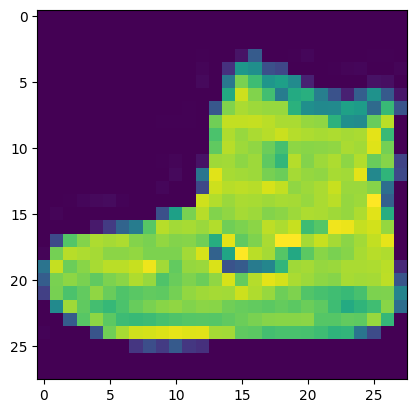

In [39]:
import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[0]
plt.imshow(img[0])
print(f"Label:{label}")
img.shape

In [44]:
max= torch.max(img)
min = torch.min(img)
scale = max-min
print(scale)

from abstract import abstractTensor as AT

x=AT(img,alpha =0.01*scale*torch.ones(28*28))
x=x.abstract_tensor()
x.shape
x=x.to(device)
print(x.shape)


tensor(5.)
torch.Size([1, 28, 28])
torch.Size([786, 1, 28, 28])


In [45]:
with torch.no_grad():
   result_1= model(x[0].unsqueeze(0))  
 
   result,x_min,x_max,x_true=model.abstract_forward(x,add_symbol=False,device=torch.device('cpu'))

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")

/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


x.shape=torch.Size([786, 1, 28, 28])
x.shape=torch.Size([786, 16, 26, 26])
x.shape torch.Size([786, 32, 24, 24])
x.shape=torch.Size([786, 32, 24, 24])
x.shape=torch.Size([786, 32, 24, 24])
okqsdqd
x_result.shape torch.Size([786, 32, 12, 12])
x_result_1.shape torch.Size([786, 32, 12, 12])
x_result.shape=torch.Size([786, 32, 12, 12])
okok
x.shape=torch.Size([786, 32, 24, 24])
x.shape=torch.Size([786, 32, 24, 24])
y_min       =  tensor([-40.4226, -42.4901, -49.3240, -43.2498, -22.5819, -51.0076, -48.5738,
        -46.7648, -45.9595, -45.5057])
y_max       =  tensor([72.0277, 78.7407, 87.0815, 78.8391, 35.4394, 99.9589, 89.8554, 83.7662,
        92.5483, 83.6891])
center Ztp  =  tensor([15.8025, 18.1253, 18.8788, 17.7947,  6.4287, 24.4757, 20.6408, 18.5007,
        23.2944, 19.0917])
y_true      =  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4255, 0.0000, 0.0000, 1.0786,
         0.0000]])
y_max-x_min =  tensor([112.4503, 121.2308, 136.4055, 122.0889,  58.0213, 150.9665, 138.4292,
 

In [46]:
with torch.no_grad():
   result_1= model(x[0].unsqueeze(0))  
 
   result,x_min,x_max,x_true=model.abstract_forward(x,add_symbol=True,device=torch.device('cpu'))

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")


x.shape=torch.Size([786, 1, 28, 28])
x.shape=torch.Size([1375, 16, 26, 26])
x.shape torch.Size([4717, 32, 24, 24])
x.shape=torch.Size([4717, 32, 24, 24])
x.shape=torch.Size([4717, 32, 24, 24])
okqsdqd
x_result.shape torch.Size([4717, 32, 12, 12])
x_result_1.shape torch.Size([4717, 32, 12, 12])
x_result.shape=torch.Size([4717, 32, 12, 12])
okok
x.shape=torch.Size([4717, 32, 24, 24])
x.shape=torch.Size([4717, 32, 24, 24])
y_min       =  tensor([-11.3877, -12.4670, -14.5835, -12.3904,  -4.7018, -15.2006, -15.0953,
        -12.8783, -14.2625, -14.6799])
y_max       =  tensor([17.2644, 20.2509, 22.4207, 20.5082,  5.9007, 33.2228, 26.3979, 20.4350,
        32.2409, 25.5807])
center Ztp  =  tensor([2.9384, 3.8920, 3.9186, 4.0589, 0.5995, 9.0111, 5.6513, 3.7783, 8.9892,
        5.4504])
y_true      =  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.7827, 0.0000, 0.0000, 3.5591,
         0.0000]])
y_max-x_min =  tensor([28.6521, 32.7179, 37.0042, 32.8985, 10.6026, 48.4233, 41.4932, 33.3132,


Voici le premier affichage de relevance calculé par AbstractTorch

tensor(5)
torch.Size([784])


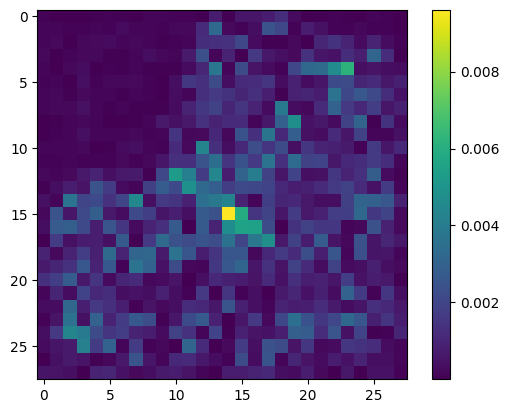

In [47]:
value=torch.argmax(result[0])
print(value)
concat= torch.abs(result[1:785,value])
print(concat.size())

concat = concat.reshape(28,28)
plt.imshow(torch.abs(concat.cpu()).numpy(), cmap='viridis')
plt.colorbar()

In [ ]:
print(result[3:5])

In [ ]:
conv= nn.Conv2d(1,16,3)
conv.weight.data=torch.abs(conv.weight.data)
conv.weight

In [2]:
from abstractModule import AbstractMaxpool2D as AM

In [26]:
class AbstractNN2(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN2,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,16,3,device=self.device)
        self.conv3=nn.Conv2d(16,32,3,device=self.device) 
        self.conv4=nn.Conv2d(32,32,3,device=self.device)
        self.maxpool=nn.MaxPool2d(2,2)
        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(3200,6272,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(6272,6272,device=self.device))
        self.fc3=nn.Sequential(nn.Flatten(),nn.Linear(6272,6272,device=self.device))
        self.fc4=nn.Sequential(nn.Flatten(),nn.Linear(6272,6272,device=self.device))
        self.fc5=nn.Sequential(nn.Flatten(),nn.Linear(6272,512,device=self.device))
        self.fc6=nn.Sequential(nn.Flatten(),nn.Linear(512,256,device=self.device))
        self.fc7=nn.Sequential(nn.Flatten(),nn.Linear(256,8,device=self.device))

    
    def forward(self,x,add_symbol=False,device = torch.device("cpu")):

        self.device = device
        x_true = x
        x_true = x_true[0].unsqueeze(0)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
       
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv3,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv4,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")

        x,x_min,x_max,x_true = AM.abstract_maxpool2D(self.maxpool,x,x_true,device=self.device)
        print(f"x.shape:{x.shape}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc3,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc4,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc5,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc6,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")

        x,x_min,x_max,x_true = AL.abstract_linear(self.fc7,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        return x,x_min,x_max,x_true

In [30]:
img = torch.randn(1,28,28)
from abstract import abstractTensor as AT

x=AT(img,alpha =0.01*torch.ones(28*28))
x=x.abstract_tensor()
x.shape
x=x.to(device)
print(x.shape)
model =AbstractNN2(num_depth=1,device=torch.device('cpu'))


model(x)

torch.Size([1, 28, 28])
torch.Size([786, 1, 28, 28])
lenx:786
x.shape=torch.Size([786, 1, 28, 28])
lenx:786
x.shape=torch.Size([786, 16, 26, 26])
lenx:786
x.shape=torch.Size([786, 16, 24, 24])
lenx:786
x.shape=torch.Size([786, 32, 22, 22])
lenx:786
x.shape torch.Size([786, 32, 20, 20])
x.shape=torch.Size([786, 32, 20, 20])
x.shape=torch.Size([786, 32, 20, 20])
okqsdqd
x_result.shape torch.Size([786, 32, 10, 10])
x_result_1.shape torch.Size([786, 32, 10, 10])
x_result.shape=torch.Size([786, 32, 10, 10])
okok
x.shape=torch.Size([786, 32, 20, 20])


RuntimeError: The size of tensor a (1990) must match the size of tensor b (786) at non-singleton dimension 0